This notebook provides code to run the simulation presented in the research notes "How Collaborative Theory Formation Reduces Epistemic Uncertainty." First, we import all required packages.

In [73]:
import numpy as np
import pandas as pd
import itertools as it
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.integrate
import scipy.spatial
import scipy.misc
from scipy.special import rel_entr
import random
from tqdm import tqdm

Next, we define three crucial functions:

1. the probability distribution $p(Y^{*}|\mathbf{x})$,
2. the probability distribution $p(Y^{*}|\boldsymbol{\theta},\mathbf{x})$, and 
3. the standpoint function $\gamma$.


In [74]:
def prob_y_given_x(y,x,B,minimum,maximum):
    if y == minimum:
        return scipy.stats.norm.cdf(y,0,np.sum(np.sqrt(x**2)))
    if y == maximum:
        return 1 - scipy.stats.norm.cdf(y,0,np.sum(np.sqrt(x**2)))
    else:
        return scipy.stats.norm.cdf(y,0,np.sum(np.sqrt(x**2))) - scipy.stats.norm.cdf(y-B,0,np.sum(np.sqrt(x**2)))

def gamma(i,j,K,M,N):
    return np.sum([K[l][j] for l in range(0,N)])/N +.001

def prob_y_given_Hx(y,x,hat_theta,K,M,N,B,minimum,maximum,mean_estimate,sd_estimate):
    if y == minimum:
        return scipy.stats.norm.cdf(y,np.mean(mean_estimate),np.sqrt(np.mean(sd_estimate)**2))
    if y == maximum:
        return 1 - scipy.stats.norm.cdf(y+B,np.mean(mean_estimate),np.sqrt(np.mean(sd_estimate)**2))
    else:
        return scipy.stats.norm.cdf(y,np.mean(mean_estimate),np.sqrt(np.mean(sd_estimate)**2)) - scipy.stats.norm.cdf(y-B,np.mean(mean_estimate),np.sqrt(np.mean(sd_estimate)**2))

Now we run the simulation for the first case, where new group members are recruited under the expectation that they will measure statistically important parameters. On a 2020 Macbook pro, this takes approximately 35 minutes.

In [75]:
Ns_contrast = []
kl_estimates_contrast = []
ratios_contrast = []
B=20
minimum = -1000
maximum = 1000


for alpha in tqdm([.1,.2,.3,.4,.5,.6,.7,.8,.9]):
    M = 100
    Q = alpha*M
    for beta in range(0,100):
        x = np.random.normal(0,1,M) #Generates the observed parameter vector
        theta = np.random.normal(0,1,M) #Generates the unobserved paramter vector.
        N=10
        #The next few lines build a matrix K such that k_{ij}=1 if parameter j is in individual i's estimation set, with k_{ij}=0 otherwise.
        K = np.zeros((N,M))
        weights = [np.abs(theta[j])/np.sum(np.abs(theta)) for j in range(0,M)]
        for i in range(0,N):
            arr = np.random.choice(np.arange(0,M),p=weights,size=int(Q), replace=False)
            for j in range(0,M):
                if j in arr:
                    K[i][j] = 1
                else:
                    K[i][j] = 0
        #The next few lines update the matrix K as we add more members the the group.
        for w in range(0,31):
            N = 10+w
            Ns_contrast = np.append(Ns_contrast,[N])
            ratios_contrast = np.append(ratios_contrast,[alpha])
            K = np.append(K,[np.zeros(M)],axis=0)
            arr2 = np.random.choice(np.arange(0,M),p=weights,size=int(Q), replace=False) #Note that here we generate the estimate set by sampling
            #from a distribution weighted according to the importance of the unknown parameters
            for j in range(0,M):
                if j in arr2:
                    K[N][j] = 1
                else:
                    K[N][j] = 0
            #The next few lines generate the parameter estimates for each individual.
            if w==0:
                hat_theta = np.zeros((N,M))
                for i in range(0,N):
                    for j in range(0,M):
                        if K[i][j] == 1:
                            hat_theta[i][j] = np.random.normal(theta[j],gamma(i,j,K,M,N))
                        
            else:
                hat_theta = np.append(hat_theta,[np.zeros(M)],axis=0)
                for j in range(0,M):
                        if K[N-1][j] == 1:
                            hat_theta[N-1][j] = np.random.normal(theta[j],gamma(i,j,K,M,N))

            
            #The remaining lines calculate the relevant probability distributions and KL-estimates for the group.
            mean_estimate = [np.dot(hat_theta[i],x) for i in range(0,N)]

            
            sd_estimate = [np.sqrt(np.dot([gamma(i,j,K,M,N) for j in range(0,M)],x)**2) for i in range(0,N)]
           
        
            p_y_given_Hx = [prob_y_given_Hx(i,x,hat_theta,K,M,N,B,minimum,maximum,mean_estimate,sd_estimate) for i in range(minimum,maximum+B,B)]
            p_y_given_x = [prob_y_given_x(i,x,B,minimum,maximum) for i in range(minimum,maximum+B,B)]
            kl_estimates_contrast = np.append(kl_estimates_contrast,[sum(rel_entr(p_y_given_Hx,p_y_given_x))])

100%|██████████| 9/9 [34:53<00:00, 232.56s/it]


After completing the simulation, we run a linear regression to get a sense of the statistical relationships between variables.

In [85]:
arr = np.hstack((Ns_contrast.reshape(-1,1),kl_estimates_contrast.reshape(-1,1),ratios_contrast.reshape(-1,1)))
df = pd.DataFrame(arr,columns=['N','MI','Ratio'])
mod = smf.ols(formula = 'MI ~ N + Ratio + N:Ratio',data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     MI   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     961.4
Date:                Sun, 17 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:35:12   Log-Likelihood:                -9801.8
No. Observations:               27900   AIC:                         1.961e+04
Df Residuals:                   27896   BIC:                         1.964e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0871      0.013    156.702      0.0

And finally, we generate the heatmap shown in Figure 1(a).

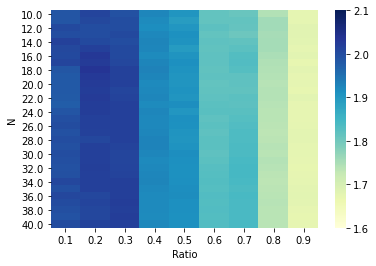

In [77]:
pivot = df.groupby(['N','Ratio'])['MI'].aggregate('mean').unstack()
sns.heatmap(pivot,cmap='YlGnBu',vmin=1.6,vmax=2.10)
plt.savefig("heatmap")

Next, we re-run the simulation for the case in which we aim to recruit individuals to the group who are more likely to sample uncommon parameters. This also takes about 35 minutes on my machine.

In [79]:
Ns = []
kl_estimates = []
ratios = []
B=20
minimum = -1000
maximum = 1000


for alpha in tqdm([.1,.2,.3,.4,.5,.6,.7,.8,.9]):
    M = 100
    Q = alpha*M
    for beta in range(0,100):
        x = np.random.normal(0,1,M) #Generates the observed parameter vector
        theta = np.random.normal(0,1,M) #Generates the unobserved paramter vector.
        N=10
        #The next few lines build a matrix K such that k_{ij}=1 if parameter j is in individual i's estimation set, with k_{ij}=0 otherwise.
        K = np.zeros((N,M))
        weights = [np.abs(theta[j])/np.sum(np.abs(theta)) for j in range(0,M)]
        for i in range(0,N):
            arr = np.random.choice(np.arange(0,M),p=weights,size=int(Q), replace=False)
            for j in range(0,M):
                if j in arr:
                    K[i][j] = 1
                else:
                    K[i][j] = 0
        #The next few lines update the matrix K as we add more members the the group.
        for w in range(0,31):
            N = 10+w
            Ns = np.append(Ns,[N])
            ratios = np.append(ratios,[alpha])
            K = np.append(K,[np.zeros(M)],axis=0)
            #In the following crucial line, we generate each new member's estimation set by sampling from 
            #a distribution that is inversely proportional to their standpoint function.
            arr2 = np.random.choice(np.arange(0,M),p=scipy.special.softmax(np.array([1 for j in range(0,M)])-\
                                                np.array([gamma(N,j,K,M,N) for j in range(0,M)])),size=int(Q), replace=False)
            for j in range(0,M):
                if j in arr2:
                    K[N][j] = 1
                else:
                    K[N][j] = 0
            #The next few lines generate the parameter estimates for each individual.
            if w==0:
                hat_theta = np.zeros((N,M))
                for i in range(0,N):
                    for j in range(0,M):
                        if K[i][j] == 1:
                            hat_theta[i][j] = np.random.normal(theta[j],gamma(i,j,K,M,N))
                        
            else:
                hat_theta = np.append(hat_theta,[np.zeros(M)],axis=0)
                for j in range(0,M):
                        if K[N-1][j] == 1:
                            hat_theta[N-1][j] = np.random.normal(theta[j],gamma(i,j,K,M,N))

            #The remaining lines calculate the relevant probability distributions and KL-estimates for the group.
            mean_estimate = [np.dot(hat_theta[i],x) for i in range(0,N)]

            
            sd_estimate = [np.sqrt(np.dot([gamma(i,j,K,M,N) for j in range(0,M)],x)**2) for i in range(0,N)]
           
        
            p_y_given_Hx = [prob_y_given_Hx(i,x,hat_theta,K,M,N,B,minimum,maximum,mean_estimate,sd_estimate) for i in range(minimum,maximum+B,B)]
            p_y_given_x = [prob_y_given_x(i,x,B,minimum,maximum) for i in range(minimum,maximum+B,B)]
            kl_estimates = np.append(kl_estimates,[sum(rel_entr(p_y_given_Hx,p_y_given_x))])

100%|██████████| 9/9 [35:58<00:00, 239.86s/it]


Once again, we run a linear regression to get a sense of the statistical relationships between variables.

In [82]:
arr2 = np.hstack((Ns.reshape(-1,1),kl_estimates.reshape(-1,1),ratios.reshape(-1,1)))
df2 = pd.DataFrame(arr2,columns=['N','MI','Ratio'])
mod = smf.ols(formula = 'MI ~ N + Ratio + N:Ratio',data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     MI   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     838.5
Date:                Sun, 17 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:34:06   Log-Likelihood:                -9283.7
No. Observations:               27900   AIC:                         1.858e+04
Df Residuals:                   27896   BIC:                         1.861e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1312      0.013    163.013      0.0

And finally, we generate the heatmap shown in Figure 1(a).

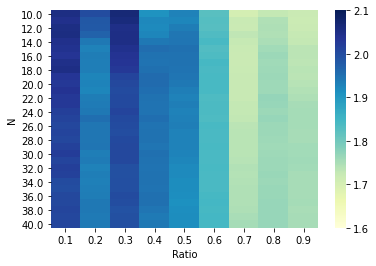

In [83]:
pivot = df2.groupby(['N','Ratio'])['MI'].aggregate('mean').unstack()
sns.heatmap(pivot,cmap='YlGnBu',vmin=1.6,vmax=2.10)
plt.savefig("heatmap")